In [2]:
import pandas as pd
from tensorflow.keras.layers import GRU, Dropout, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [4]:
df = pd.read_csv('cepea.csv', encoding = 'latin1', sep = ';')

In [6]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['À vista R$'] = pd.to_numeric(df['À vista R$'].str.replace(',', '.'), errors='coerce')
df['À vista US$'] = pd.to_numeric(df['À vista US$'].str.replace(',', '.'), errors='coerce')

In [8]:
df.set_index("Data", inplace=True)

In [10]:
serie = df["À vista US$"].values.reshape(-1, 1)

# Normalização
scaler = MinMaxScaler()
serie_normalizada = scaler.fit_transform(serie)

In [12]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 4
X, y = create_sequences(serie_normalizada, WINDOW_SIZE)

# Divisão treino/teste (ex: 80/20)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM

D:\Documentos\Jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


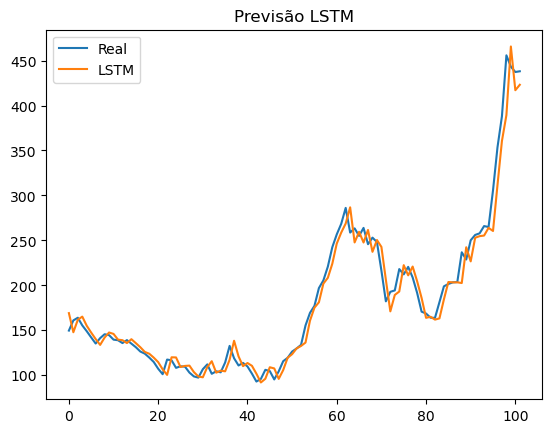

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

#model_lstm = Sequential()
#model_lstm.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
#model_lstm.add(LSTM(25, activation='tanh'))
#model_lstm.add(Dense(1))
#model_lstm.compile(optimizer='adam', loss='mse')
optimizer = Adam(learning_rate=0.00901812)

model_lstm = Sequential()
model_lstm.add(LSTM(64, activation = 'tanh', input_shape= (WINDOW_SIZE, 1)))
model_lstm.add(Dropout(0.28809))
#model_lstm.add(LSTM(128, activation = 'tanh', return_sequences=True))
#model_lstm.add(Dropout(0.214))
#model_lstm.add(LSTM(128, activation = 'tanh', return_sequences=True))
#model_lstm.add(Dropout(0.214))
#model_lstm.add(LSTM(128, activation = 'tanh'))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer = optimizer)
model_lstm.fit(X_train, y_train, epochs=144, batch_size = 32, verbose=0)

# Previsões
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_lstm, label='LSTM')
plt.legend()
plt.title("Previsão LSTM")
plt.show()

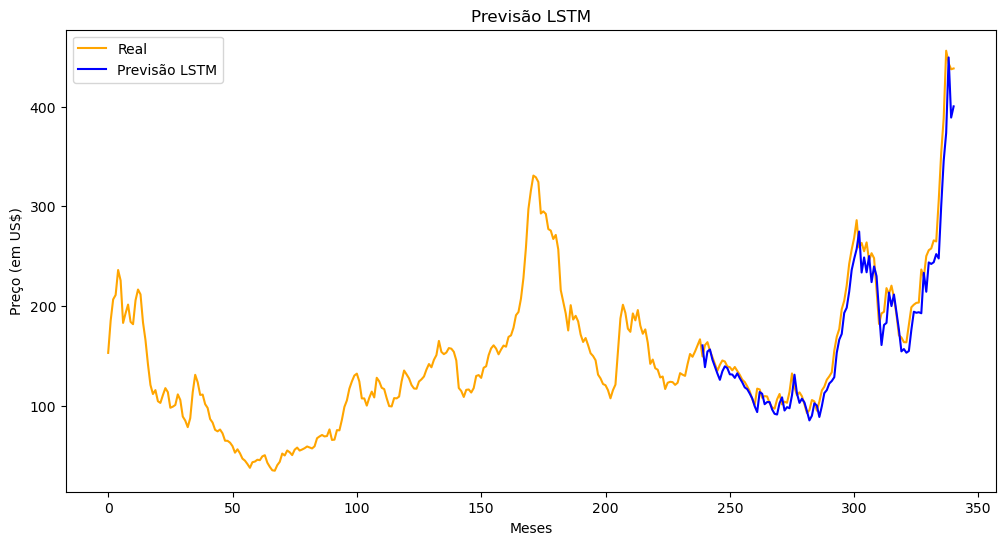

In [18]:
serie_real_inv = scaler.inverse_transform(serie_normalizada)

# Ajustar a forma do y_pred_lstm
y_pred_lstm = y_pred_lstm.reshape(-1, 1)

# Agora, criar a série com NaNs até o ponto inicial de teste
y_pred_full = np.empty_like(serie_real_inv)
y_pred_full[:] = np.nan
y_pred_full[-len(y_pred_lstm):] = y_pred_lstm

# Plot
plt.figure(figsize=(12, 6))
plt.plot(serie_real_inv, label='Real', color='orange')
plt.plot(y_pred_full, label='Previsão LSTM', color='blue')
plt.title("Previsão LSTM")
plt.xlabel("Meses")
plt.ylabel("Preço (em US$)")
plt.legend()
plt.savefig('preco_lstm')
plt.show()

# GRU

D:\Documentos\Jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


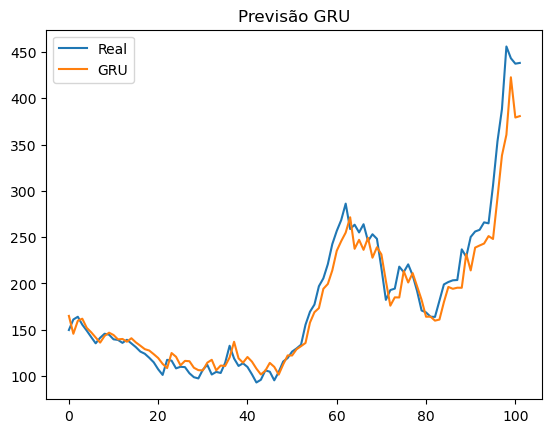

In [22]:
from keras.layers import GRU  # ou: from keras.layers import SimpleRNN

#model_gru = Sequential()
#model_gru.add(GRU(50, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
#model_gru.add(GRU(25, activation='tanh'))
#model_gru.add(Dense(1))
#model_gru.compile(optimizer='adam', loss='mse')
#model_gru.fit(X_train, y_train, epochs=100, verbose=1)

optmizer = Adam(learning_rate = 0.009018125)
model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model_gru.add(Dropout(0.33267))
model_gru.add(GRU(100, return_sequences=True))
model_gru.add(Dropout(0.33267))
model_gru.add(GRU(100,))
model_gru.add(Dropout(0.33267))
model_gru.add(Dense(1))
model_gru.compile(loss='mse', optimizer= optmizer)
model_gru.fit(X_train, y_train, epochs=144, batch_size = 32, verbose=0)

y_pred_gru = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_gru, label='GRU')
plt.legend()
plt.title("Previsão GRU")
plt.show()

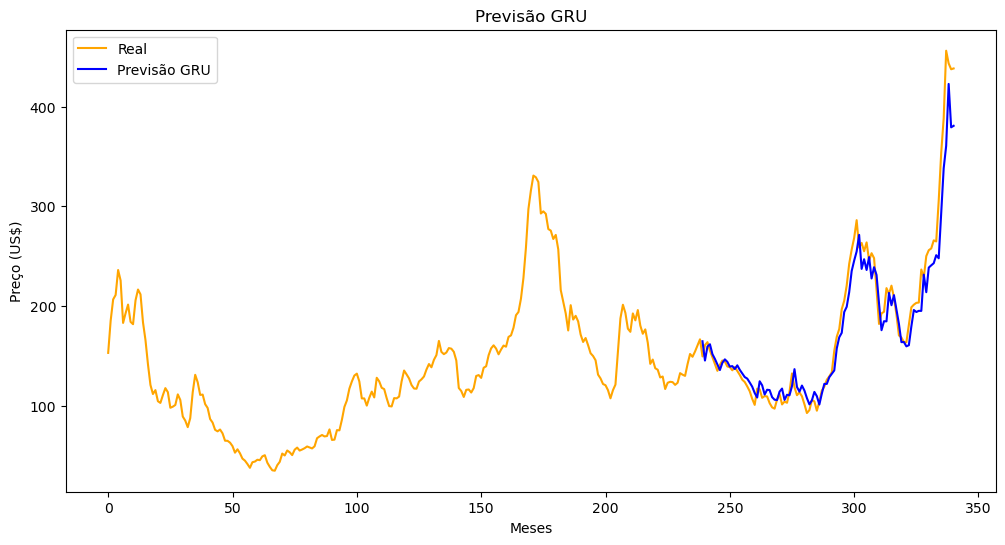

In [25]:
serie_real_inv = scaler.inverse_transform(serie_normalizada)

# Ajustar a forma do y_pred_lstm
y_pred_gru = y_pred_gru.reshape(-1, 1)

# Agora, criar a série com NaNs até o ponto inicial de teste
y_pred_full = np.empty_like(serie_real_inv)
y_pred_full[:] = np.nan
y_pred_full[-len(y_pred_gru):] = y_pred_gru

# Plot
plt.figure(figsize=(12, 6))
plt.plot(serie_real_inv, label='Real', color='orange')
plt.plot(y_pred_full, label='Previsão GRU', color='blue')
plt.title("Previsão GRU")
plt.xlabel("Meses")
plt.ylabel("Preço (US$)")
plt.legend()
plt.savefig('preco_gru.png')
plt.show()

# Avaliações

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape_train = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} - MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f} | MAPE: {mape_train} ")

In [16]:
print_metrics(y_test_inv, y_pred_lstm, "LSTM")
print_metrics(y_test_inv, y_pred_gru, "GRU")

LSTM - MAE: 10.92 | RMSE: 14.86 | R²: 0.9673 | MAPE: 6.076225982807561 
GRU - MAE: 10.64 | RMSE: 14.25 | R²: 0.9699 | MAPE: 6.237371787493017 


# MELHORES HIPER PARÂMETROS PARA CADA MODELO